In [0]:
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 39kB/s 
     |████████████████████████████████| 450kB 41.7MB/s 
     |████████████████████████████████| 3.8MB 37.1MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/chunyeow/climate-malaysia/master/tas_1901_2016_MYS.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-03-01 10:15:10--  https://raw.githubusercontent.com/chunyeow/climate-malaysia/master/tas_1901_2016_MYS.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58367 (57K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  57.00K  --.-KB/s    in 0.01s   

2020-03-01 10:15:10 (5.79 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [58367/58367]



1392


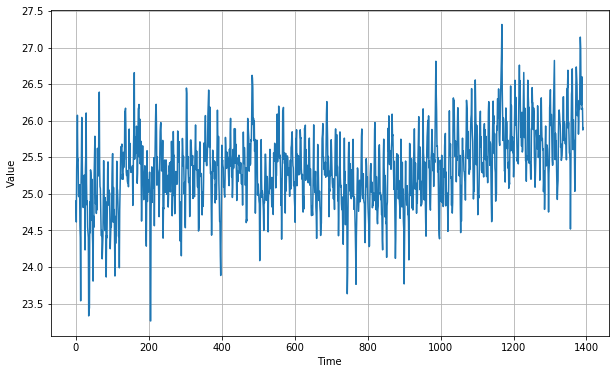

In [0]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step = 0
  for row in reader:
    temps.append(float(row[0]))
    time_step.append(step)
    step = step + 1

print(step)

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 1344
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 48
batch_size = 28
shuffle_buffer_size = 1000



In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 48
batch_size = 28
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=24, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1344,)
Epoch 1/100
47/47 [==============================] - 4s 81ms/step - loss: 43.1888 - mae: 43.7456
Epoch 2/100
47/47 [==============================] - 1s 16ms/step - loss: 34.2030 - mae: 34.7968
Epoch 3/100
47/47 [==============================] - 1s 17ms/step - loss: 15.2155 - mae: 15.9055
Epoch 4/100
47/47 [==============================] - 1s 17ms/step - loss: 2.5220 - mae: 2.9683
Epoch 5/100
47/47 [==============================] - 1s 16ms/step - loss: 2.1580 - mae: 2.5815
Epoch 6/100
47/47 [==============================] - 1s 17ms/step - loss: 1.9834 - mae: 2.4022
Epoch 7/100
47/47 [==============================] - 1s 16ms/step - loss: 1.8193 - mae: 2.2351
Epoch 8/100
47/47 [==============================] - 1s 16ms/step - loss: 1.6623 - mae: 2.0775
Epoch 9/100
47/47 [==============================] - 1s 16ms/step - loss: 1.5052 - mae: 1.9182
Epoch 10/100
47/47 [=================

[1e-08, 0.0001, 0, 60]

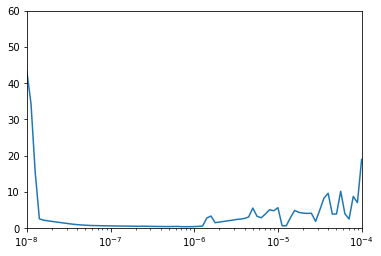

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=48, batch_size=28, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=24, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
47/47 [==============================] - 4s 80ms/step - loss: 7.9133 - mae: 8.4906
Epoch 2/150
47/47 [==============================] - 1s 16ms/step - loss: 0.5743 - mae: 0.8871
Epoch 3/150
47/47 [==============================] - 1s 16ms/step - loss: 0.4082 - mae: 0.6843
Epoch 4/150
47/47 [==============================] - 1s 16ms/step - loss: 0.3284 - mae: 0.6016
Epoch 5/150
47/47 [==============================] - 1s 16ms/step - loss: 0.2937 - mae: 0.5652
Epoch 6/150
47/47 [==============================] - 1s 16ms/step - loss: 0.2768 - mae: 0.5482
Epoch 7/150
47/47 [==============================] - 1s 16ms/step - loss: 0.2622 - mae: 0.5313
Epoch 8/150
47/47 [==============================] - 1s 16ms/step - loss: 0.2519 - mae: 0.5202
Epoch 9/150
47/47 [==============================] - 1s 16ms/step - loss: 0.2418 - mae: 0.5094
Epoch 10/150
47/47 [==============================] - 1s 16ms/step - loss: 0.2302 - mae: 0.4953
Epoch 11/150
47/47 [=============================

In [0]:
print(series)
print(window_size)
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

[24.9034 24.6155 25.3411 ... 26.1699 25.8739 25.9052]
48


[1344 1345 1346 1347 1348 1349 1350 1351 1352 1353 1354 1355 1356 1357
 1358 1359 1360 1361 1362 1363 1364 1365 1366 1367 1368 1369 1370 1371
 1372 1373 1374 1375 1376 1377 1378 1379 1380 1381 1382 1383 1384 1385
 1386 1387 1388 1389 1390 1391]


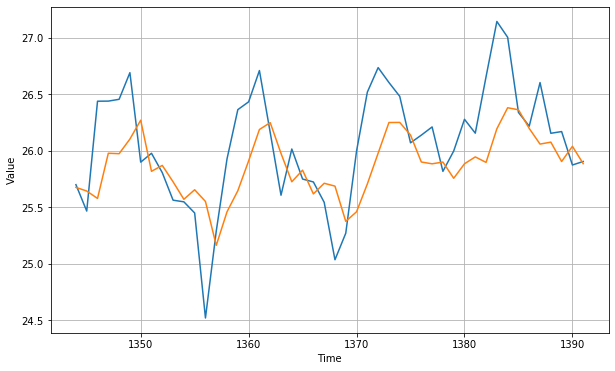

In [0]:
plt.figure(figsize=(10, 6))
print(time_valid)
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

0.3443177

In [0]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[25.92479  25.637568 25.743475 25.88271  26.093779 26.379923 26.341343
 26.244122 26.023384 25.949215 25.925964 25.887602 26.014072 26.110613
 26.13482  26.414722 26.50298  26.51805  26.394283 26.210365 26.187387
 26.007996 26.141666 26.014446]
